In [1]:
from keras.layers import Input,Dense
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import keras

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [101]:
%%time
import os
for dirPath, dirNames, fileNames in os.walk("figure"):
    pass
data=[]
for name in fileNames:
    path='figure/'+name
    img=mpimg.imread(path)
    #data.append(img[6:34,6:34,0:4])
    data.append(img[4:36,4:36,0:4])
data=np.array(data)

x_train=data[:-3]
x_test=data[-3:]

x_train=x_train.reshape(len(x_train),32,32,4)
x_test=x_test.reshape(len(x_test),32,32,4)

print('x_train shape=',x_train.shape)
print('x_test shape=',x_test.shape)

x_train shape= (789, 32, 32, 4)
x_test shape= (3, 32, 32, 4)
CPU times: user 169 ms, sys: 13.8 ms, total: 182 ms
Wall time: 183 ms


In [127]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Layer, Lambda, Flatten,Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img=Input(shape=(32,32,4))

conv1=Conv2D(32,(2,2),activation='relu',padding='same',strides=1)(input_img)
#maxpool1=MaxPooling2D((2,2),padding='same')(conv1)
conv2=Conv2D(32,(2,2),activation='relu',padding='same',strides=1)(conv1)
#maxpool2=MaxPooling2D((2,2),padding='same')(conv2)
conv3=Conv2D(32,(2,2),activation='relu',padding='same',strides=1)(conv2)
maxpool3=MaxPooling2D((2,2),padding='same')(conv3)
flat=Flatten()(maxpool3)
dense1=Dense(16*16)(flat)
dense2=Dense(16*8)(dense1)
z_mean=Dense(32)(dense2)
z_log_var=Dense(32)(dense2)
def sampling(args):
    z_mean, z_log_var = args
    #epsilon是常態分布下亂數取出的noise
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 1), mean=0.,
                              stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling)([z_mean, z_log_var])
encoder=Model(input_img,z)

decoder_input=Input(shape=(32,))
dec_dense1=Dense(16*8)
dec_dense2=Dense(16*16*32)
dec_reshape=Reshape((16,16,32))
dec_conv1=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=1)
#dec_ups1=UpSampling2D((2,2))
dec_conv2=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=1)
#dec_ups2=UpSampling2D((2,2))
dec_conv3=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=1)
dec_ups3=UpSampling2D((2,2))
dec_conv4=Conv2D(4,(3,3),activation='sigmoid',padding='same',strides=1)

x=dec_dense1(z)
x=dec_dense2(x)
x=dec_reshape(x)
x=dec_conv1(x)
#x=dec_ups1(x)
x=dec_conv2(x)
#x=dec_ups2(x)
x=dec_conv3(x)
x=dec_ups3(x)
x=dec_conv4(x)

decoder=dec_dense1(decoder_input)
decoder=dec_dense2(decoder)
decoder=dec_reshape(decoder)
decoder=dec_conv1(decoder)
#decoder=dec_ups1(decoder)
decoder=dec_conv2(decoder)
#decoder=dec_ups2(decoder)
decoder=dec_conv3(decoder)
decoder=dec_ups3(decoder)
decoder=dec_conv4(decoder)

decoder=Model(decoder_input,decoder)


from keras import metrics
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        # 呼叫Layer的建構子__init__
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, input_img, x):
        input_img=Flatten()(input_img)
        x=Flatten()(x)
        xent_loss = 32 *32* (metrics.binary_crossentropy((input_img), (x)))
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1)
        return K.sum(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([input_img, x])
vae = Model(input_img, y)
vae.compile(optimizer='RMSprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 32, 32, 4)    0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 32, 32, 32)   544         input_67[0][0]                   
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, 32, 32, 32)   4128        conv2d_194[0][0]                 
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 32, 32, 32)   4128        conv2d_195[0][0]                 
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Output "custom_variational_layer_28" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_28" during training.


In [139]:
vae.fit(x=x_train,shuffle=True,epochs=100,validation_data=(x_test,None),batch_size=32)


import json
from keras.applications import imagenet_utils
vae.save_weights('./vae1_weight.h5')

Train on 789 samples, validate on 3 samples
Epoch 1/100
789/789 [==============================] - 5s 7ms/step - loss: 4592.7560 - val_loss: 2977.2241
Epoch 2/100
789/789 [==============================] - 5s 7ms/step - loss: 4564.4460 - val_loss: 3022.4158
Epoch 3/100
789/789 [==============================] - 5s 7ms/step - loss: 4696.8161 - val_loss: 2863.2937
Epoch 4/100
789/789 [==============================] - 5s 7ms/step - loss: 4535.9718 - val_loss: 2902.5129
Epoch 5/100
789/789 [==============================] - 5s 7ms/step - loss: 4541.7683 - val_loss: 2915.7607
Epoch 6/100
789/789 [==============================] - 5s 7ms/step - loss: 4596.8635 - val_loss: 3104.4138
Epoch 7/100
789/789 [==============================] - 5s 7ms/step - loss: 4593.9829 - val_loss: 2815.5229
Epoch 8/100
789/789 [==============================] - 5s 7ms/step - loss: 4572.8172 - val_loss: 2904.8379
Epoch 9/100
789/789 [==============================] - 5s 7ms/step - loss: 4573.7432 - val_loss: 294

789/789 [==============================] - 5s 7ms/step - loss: 4466.1071 - val_loss: 3070.2344
Epoch 77/100
789/789 [==============================] - 5s 7ms/step - loss: 4514.2598 - val_loss: 3087.3018
Epoch 78/100
789/789 [==============================] - 5s 7ms/step - loss: 4477.9634 - val_loss: 2800.9680
Epoch 79/100
789/789 [==============================] - 5s 7ms/step - loss: 4468.7736 - val_loss: 3111.9839
Epoch 80/100
789/789 [==============================] - 5s 7ms/step - loss: 4473.5471 - val_loss: 2973.1091
Epoch 81/100
789/789 [==============================] - 5s 7ms/step - loss: 4501.2867 - val_loss: 2841.8735
Epoch 82/100
789/789 [==============================] - 5s 7ms/step - loss: 4500.6940 - val_loss: 2964.5369
Epoch 83/100
789/789 [==============================] - 5s 7ms/step - loss: 4473.6114 - val_loss: 3129.0791
Epoch 84/100
789/789 [==============================] - 5s 7ms/step - loss: 4496.5675 - val_loss: 2940.2627
Epoch 85/100
789/789 [===================

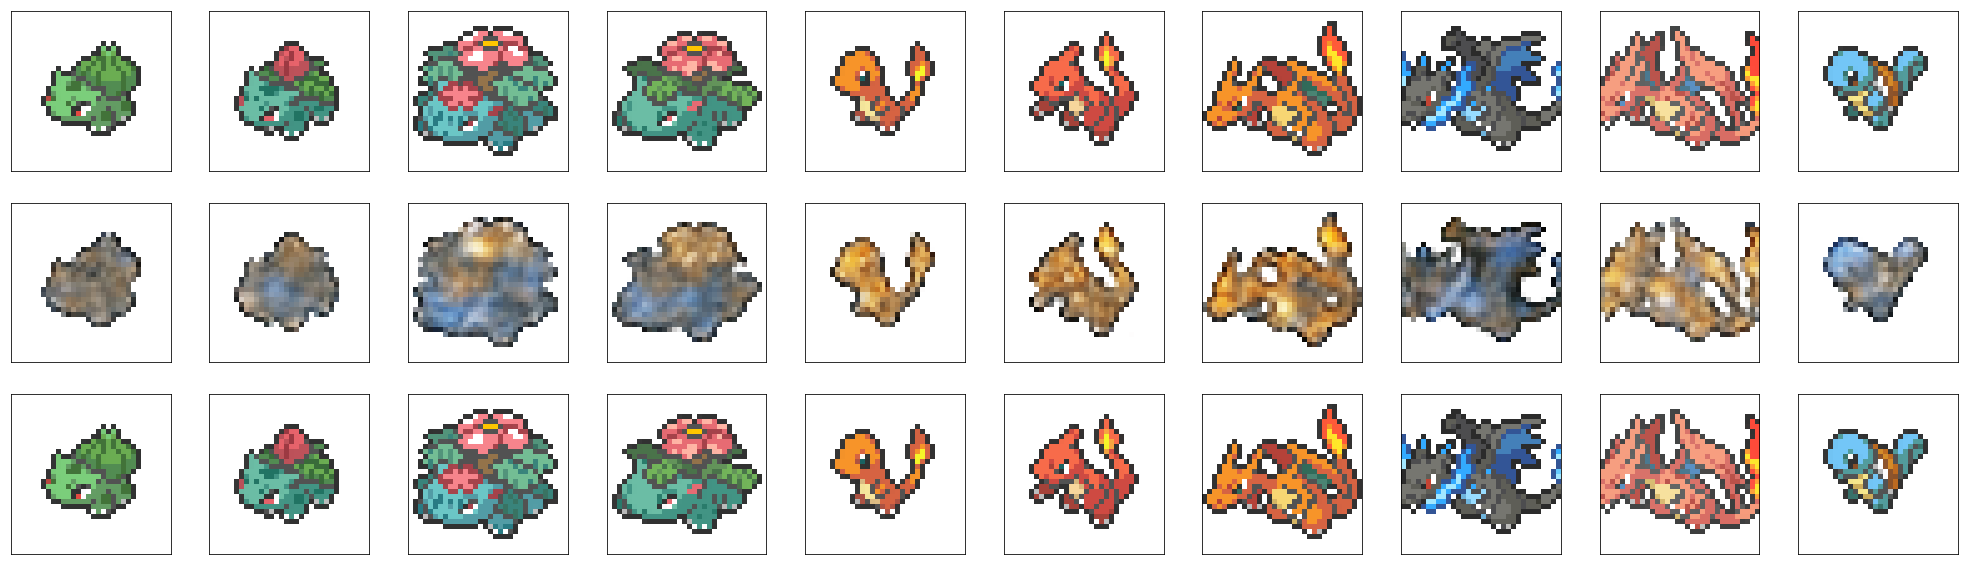

In [140]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)
hello=vae.predict(x_train)
n = 10  # how many digits we will display
plt.figure(figsize=(35, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    imgplot = plt.imshow(x_train[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    imgplot = plt.imshow(hello[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

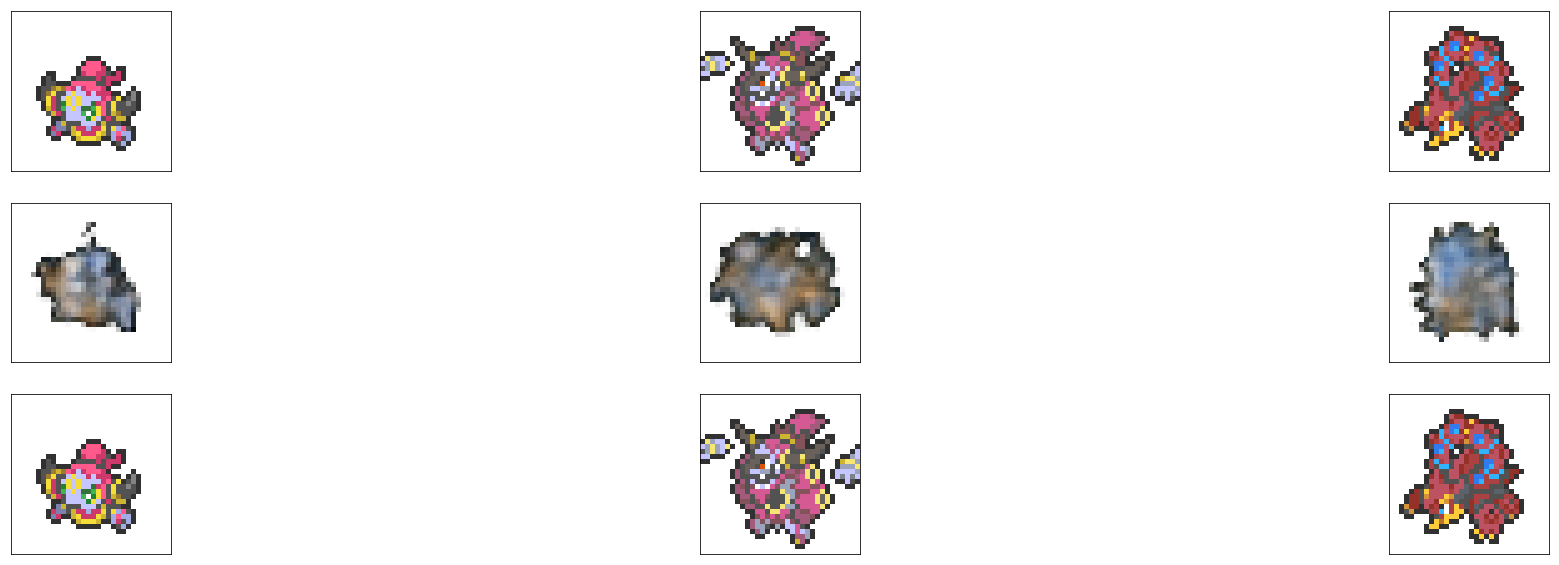

In [142]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
hello=vae.predict(x_test)
n = 3  # how many digits we will display
plt.figure(figsize=(35, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    imgplot = plt.imshow(x_test[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    imgplot = plt.imshow(decoded_imgs[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    imgplot = plt.imshow(hello[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [122]:
from keras.models import model_from_json
vae.load_weights('./vae1_weight.h5')

